_________________________

# Описание проекта: Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

    Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
    Контролировать добросовестность кассиров при продаже алкоголя.

Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

## Исследовательский анализ данных

In [2]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [3]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


In [4]:
labels.shape

(7591, 2)

In [5]:
labels

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
...,...,...
7586,007608.jpg,14
7587,007609.jpg,37
7588,007610.jpg,28
7589,007611.jpg,20


In [78]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


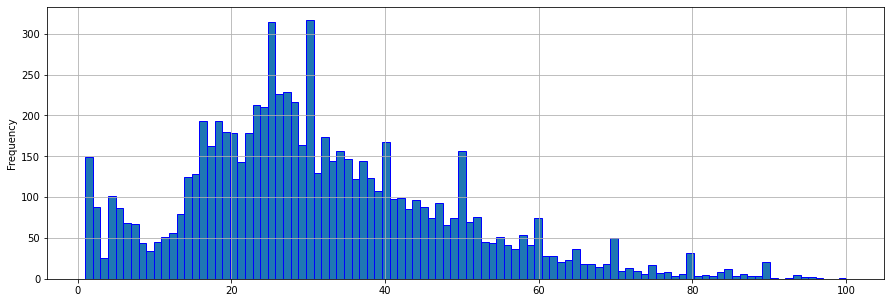

In [37]:
labels['real_age'].plot(kind='hist', ec='blue',figsize = (15,5), bins=100, grid=True);

Рассмотрим подробнее распределение для клиентов от 1 до 35 лет 

In [96]:
age = labels.pivot_table(index='real_age', values='real_age', aggfunc=['count'])
age.columns = ['count']
age

,count
real_age,
1,149
2,88
3,25
4,101
5,87
...,...
94,5
95,2
96,2


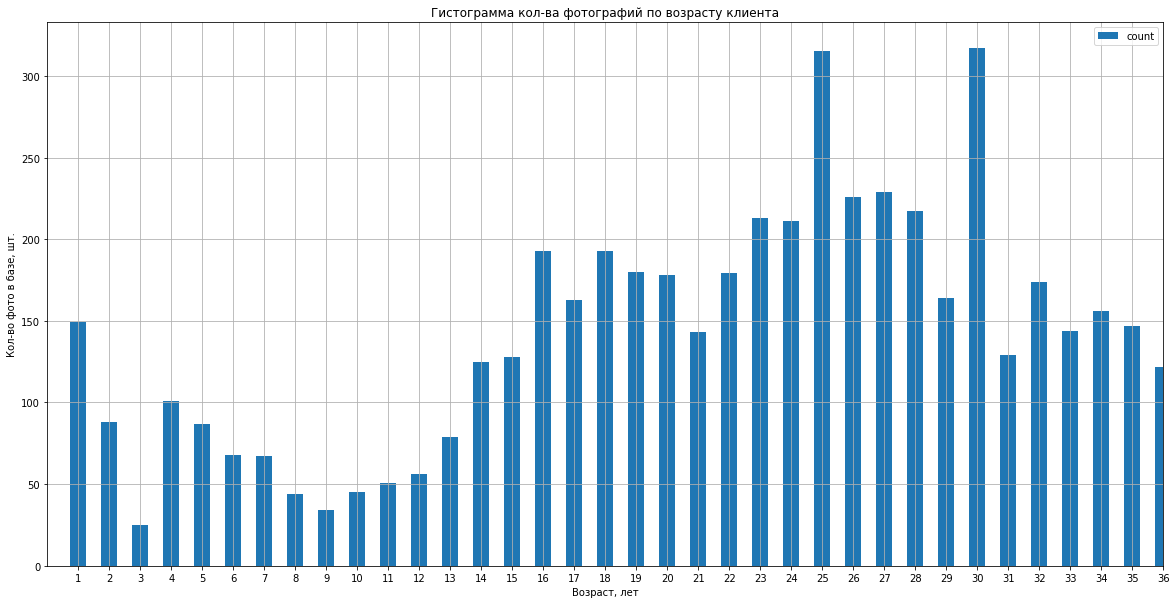

In [94]:
age.plot(kind = 'bar',figsize = (20,10),grid=True)
plt.xlim([-1, 35])
plt.title('Гистограмма распределения кол-ва фотографий по возрасту клиента')
plt.xlabel('Возраст, лет')
plt.ylabel('Кол-во фото в базе, шт.')
plt.xticks(rotation=0);
plt.show()

<div class="alert alert-block alert-info">
Вывод по датасету и гистограмме</div>    
Объем датасета составляет порядком 7600 фотографий, данного объема будет достаточно для обучения сети, отмечу, что если дефолтных фото будет вдруг недостаточно для формирования точного прогноза, то применив аугментацияю, данный объем датасета можно будет увеличить в 6-10 раз. 

Разбирая гистограмму сформированную по датасету, видим "всплекс" кол-ва фотографий для возрастов:  
    - дети (1-2 года);  
    - несовершеннолетние (для разных стран это разный возраст, но в целом здесь охвачен весь диапазон 16-21 год)  
    - молодежь (25,30 лет)  
    - и далее через 10-ток  
    Данные "всплески" не случайны, а направленены на корректную-конкретную идентификацию целевой аудитории - возрастной группы, и формирования предложений для каждой конкретной аудитории.  
    Так, для "грудничков" одни товары, для несовершеннолетних другие (+стоп алкоголь/сигаретная продукция), для активной молодежи другая и т.п.  
         Видим, что кол-во фото для категории 60+ существенно снижается, что закономерно. Сложно ожидать мега выручку от покупателя 80+..., всё же целевая группа супермаркета в "активных возрастных слоях"
    


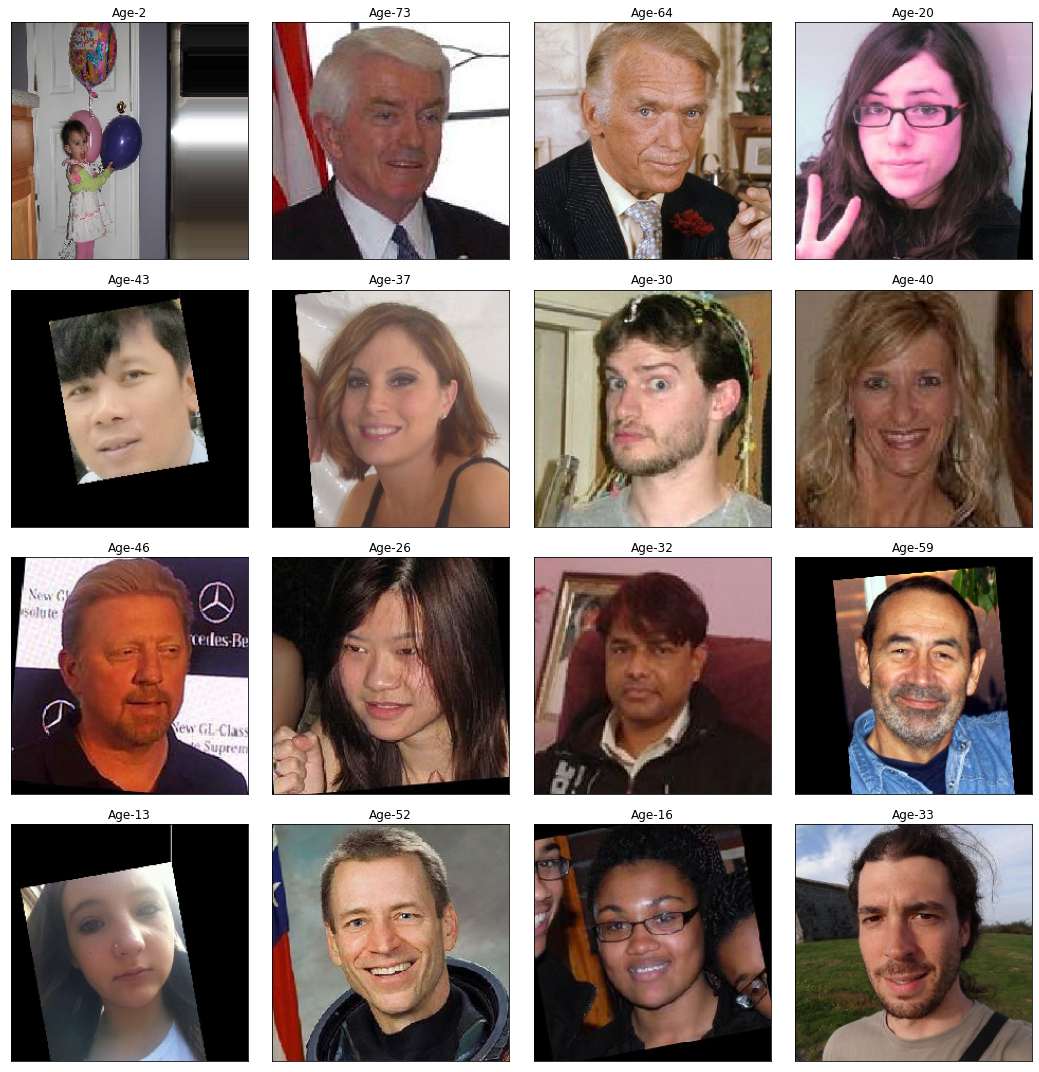

In [76]:
features, target = next(train_gen_flow)
fig = plt.figure(figsize=(15,15))
for i in range(16):
    fig.add_subplot(4, 4,i+1)
    plt.title(f"Age-{target[i]}")
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

<div class="alert alert-block alert-info">
Вывод/анализ выгруженных фотографий:</div>

Проанализировав выгружамые фотографии, предположу что:  
 - Выгружаемые фотографии не постановочные, а взяты из "жизни", возможно из социальных сетей, журналов, есть кадры из фильмов;  
 - Фотографии принадлежат как "знаменитостям", там и "обывателям", охвачены различные десятилетия (эпохи);  
 - Гендерный состав примерно одинаковый;
 - Присутствуют фотографии как в цвете так и черно белые;
 - В основном фотографии сделаны крупным планом и из жизни(т.е. пойман момент)/под углом, или фото из "журнала" под углом - данный ракурс не считаю проблемой т.к. и на кассе покупатели стоят не в "постойке смирно", а "под углом", т.е. данный формат фото будет предпочтительнее для корректной идентификации клиента;
 - Есть ряд фото, где объект на дальнем плане и/или среди посторонних объектов (кустов/инфраструктуры), данные фото думаю будут бесполезны для обучения, они будут больше как шум, но таких фото не много (по ощущению менее 5-10%)
 
 ОСНОВНОЙ загадной для меня является как изначально был идентифицирован возраст на конкретной фотографии. Точнее боюсь представить, если эта база формировалась изначально "руками", если по журналам/фильмам все понято, то как по ноунейм фото из соцсети, вытащить возраст..., то это тот еще труд ... 

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
 
def load_train(path):
    labels = pd.read_csv(path+'labels.csv')
    train_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    train_data = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path+'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345, 
        subset='training'
        )
    return train_data


def load_test(path):
    labels = pd.read_csv(path+'labels.csv')
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_data = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path+'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345, subset='validation')
    return test_data



def create_model(input_shape):
    optimizer = Adam(lr=0.0005)
    backbone = ResNet50(input_shape=input_shape, weights='imagenet', include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=7,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model




<class 'tensorflow.python.keras.engine.sequential.Sequential'>

WARNING:tensorflow:sample_weight modes were coerced from

  ...

    to  

  ['...']

WARNING:tensorflow:sample_weight modes were coerced from

  ...

    to  

  ['...']

Train for 178 steps, validate for 60 steps

Epoch 1/7

2022-06-20 07:40:26.982618: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10

2022-06-20 07:40:29.243654: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7

178/178 - 68s - loss: 204.5061 - mae: 10.6496 - val_loss: 358.8347 - val_mae: 14.0950

Epoch 2/7

178/178 - 37s - loss: 103.9575 - mae: 7.7900 - val_loss: 301.0608 - val_mae: 12.9022

Epoch 3/7

178/178 - 36s - loss: 64.9452 - mae: 6.1338 - val_loss: 350.4098 - val_mae: 13.8644

Epoch 4/7

178/178 - 37s - loss: 40.6465 - mae: 4.9150 - val_loss: 168.0062 - val_mae: 9.9382

Epoch 5/7

178/178 - 37s - loss: 27.6778 - mae: 4.0666 - val_loss: 123.4085 - val_mae: 8.7441

Epoch 6/7

178/178 - 37s - loss: 22.0294 - mae: 3.5945 - val_loss: 91.5200 - val_mae: 7.1555

Epoch 7/7

178/178 - 37s - loss: 15.3402 - mae: 3.0217 - val_loss: 81.0415 - val_mae: 6.7997

WARNING:tensorflow:sample_weight modes were coerced from

  ...

    to  

  ['...']

60/60 - 9s - loss: 81.0415 - mae: 6.7997

**Test MAE: 6.7997**


Вариант, где:
Добавлен набор изображений тренировочной выборки с перевернутыми/растянутыми/перевернутыми изображениями и уменьшен шаг градиентного спуска (с 0.0005 до 0.0001),
измен размер изображение (до 512х512)

	target_size=(512, 512)
    
    horizontal_flip=True,
	vertical_flip = True,
	rotation_range=90,
	width_shift_range=0.2,
	height_shift_range=0.2
    
    optimizer = Adam(lr=0.0001)


Train for 178 steps, validate for 60 steps

Epoch 1/7

2022-06-20 08:44:29.554997: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10

2022-06-20 08:44:31.706584: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7

178/178 - 130s - loss: 265.4353 - mae: 11.6336 - val_loss: 895.7805 - val_mae: 25.0812

Epoch 2/7

178/178 - 106s - loss: 86.2644 - mae: 6.9916 - val_loss: 782.7837 - val_mae: 23.0182

Epoch 3/7

178/178 - 106s - loss: 44.3926 - mae: 5.1324 - val_loss: 696.5025 - val_mae: 21.4049

Epoch 4/7

178/178 - 106s - loss: 27.4116 - mae: 3.9992 - val_loss: 222.2235 - val_mae: 10.9384

Epoch 5/7

178/178 - 106s - loss: 19.3847 - mae: 3.4008 - val_loss: 98.7732 - val_mae: 7.4309

Epoch 6/7

178/178 - 106s - loss: 15.5043 - mae: 3.0392 - val_loss: 77.9431 - val_mae: 6.6057

Epoch 7/7

178/178 - 106s - loss: 13.6990 - mae: 2.8582 - val_loss: 66.5733 - val_mae: 6.1510

WARNING:tensorflow:sample_weight modes were coerced from

  ...

    to  

  ['...']

60/60 - 18s - loss: 66.5733 - mae: 6.1510

**Test MAE: 6.1510**



## Анализ обученной модели

Применив архитектуру ResNet50,и обучив модель на семи эпохах, удалось достич требуемой метрики качества на тестовой выборке (Test MAE: 6.7997).   
Применив аугментацию, и "поиграв" с шагом градиентного спуска, размером изображения, удалось достигнуть размера метрики Test MAE: 6.1510 (чуть выше приложил параметры при которых удалось достич данной метрики)

<div class="alert alert-block alert-info">
<b>Полученная модель позволяет решить поставленные бизнесом задачи - ЧАСТИЧНО. Считаю, что основные проблемы с идентификацией клиента будут для возрастных групп "груднички" и несовершеннолетние. </b> 
    
    Метрика качества MAE на тестовой выборке достигает значений 6 (пусть даже 5), это говорит о том, что средний модуль отклонения будет равен 5-6 годам, т.е. если 5-6 лет отклонения для возрастной группы 30-40 лет особой роли не сыграет в предпочтениях/предлагаемых товарах, то для категории "грудничек" и несовершеннолетний, "отклонение" в 5 лет уже очень критичны, условно, предлагая "памперсы"  или алкоголь школьнику, супермаркет как минимум рискнет репутацией и "кошельком".  
    В сложившийся ситуации вижу выход в увеличении базовых фотографий для данных целевых групп (1-5 и 15-20 лет) с последующей их аугментацией. Данная мера уверен позволит снизить MAE до 2-3(хочется верить в это), что уже будет не так критично, и бизнес будет доволен.
</div>